# 샘플 데이터와 Stacking Regression 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

# 1. Data

1.1 Sample Data

In [3]:
from sklearn.datasets import make_regression

# 1000개 샘플 생성, feature은 20개 중에서 15개의 의미만 줌
data, label = make_regression(n_samples = 1000, n_features=20, n_informative=15, noise=0.1, random_state =1)

In [5]:
data.shape, label.shape

((1000, 20), (1000,))

# 1.2 Data EDA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

In [10]:
pca_data = pca.fit_transform(data)

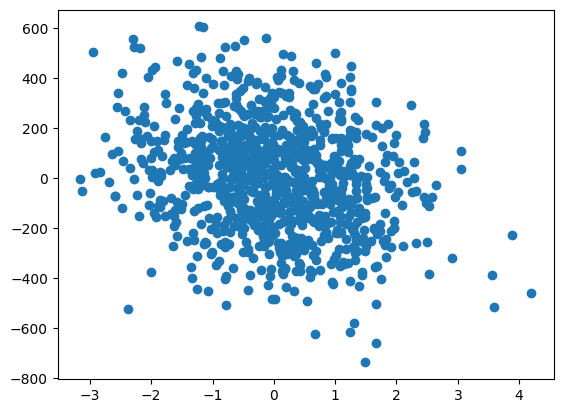

In [11]:
plt.scatter(pca_data, label)

# 1.2 Data Split

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_label, test_label = train_test_split(
    data, label, train_size=0.7, random_state=2021
)

# 2. 개별 모델의 성능

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [15]:
# dictionary =  {key:value}
models = {
    'knn': KNeighborsRegressor(), 
    'tree': DecisionTreeRegressor(),
    'svm': SVR(),
}

In [17]:
from sklearn.metrics import mean_absolute_error # 평가도구
from sklearn.model_selection import cross_val_score # 지정한 valid score 반환

In [19]:
names = []
results = []
for name, model in models.items():
  result = cross_val_score(model, train_data, train_label, cv=3, scoring="neg_mean_absolute_error")
  names += [name]
  results += [result]

In [21]:
import sklearn
sklearn.metrics.SCORERS.keys() # 사용이 가능한 키

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

In [22]:
results

[array([-105.03162689, -105.83152462, -102.13684464]),
 array([-169.80488169, -160.5476096 , -156.2103981 ]),
 array([-169.94710581, -171.22395842, -162.4710332 ])]

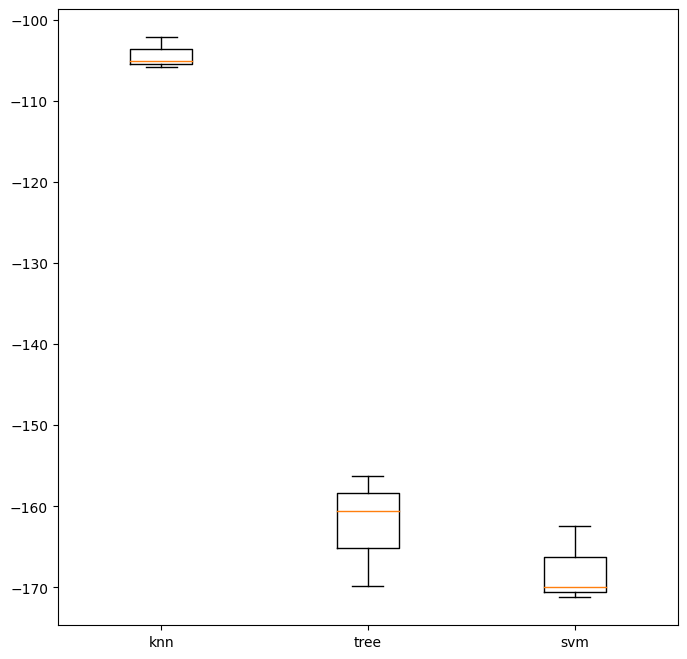

In [24]:
# 학습한 결과 boxplot 표현
plt.figure(figsize=(8,8))
plt.boxplot(results, labels=names)
plt.show()
# neg이기 때문에 가장 작은 값이 예측을 잘함
# knn > tree > svm 순으로 예측 잘함

In [25]:
# 모델을 전체 train data 학습한 후 test data를 평가한 성능
for name, model in models.items():
  model.fit(train_data, train_label)
  test_pred = model.predict(test_data)
  acc = mean_absolute_error(test_label, test_pred)
  print(f"Model {name} test mean absolute error is {acc:.4f}")

Model knn test mean absolute error is 97.7661
Model tree test mean absolute error is 161.5555
Model svm test mean absolute error is 162.5530


# **3. Stacking**

In [27]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [28]:
# estimators -> stacking에 사용할 모델들을 의미, final_estimator -> 메타 모델 의미함
# stacking 메타모델은 regression을 사용함 
stacking = StackingRegressor(
    estimators=list(models.items()),
    final_estimator=LinearRegression(),
    cv=3
)

In [30]:
stacking_result = cross_val_score(stacking, train_data, train_label, cv=3, scoring="neg_mean_absolute_error")

In [31]:
stacking_result

array([-98.10760043, -84.18129655, -93.80180117])

In [33]:
all_result=[]
all_result.extend(results)
all_result.append(stacking_result) # 기존 boxplot에 stacking_result추가

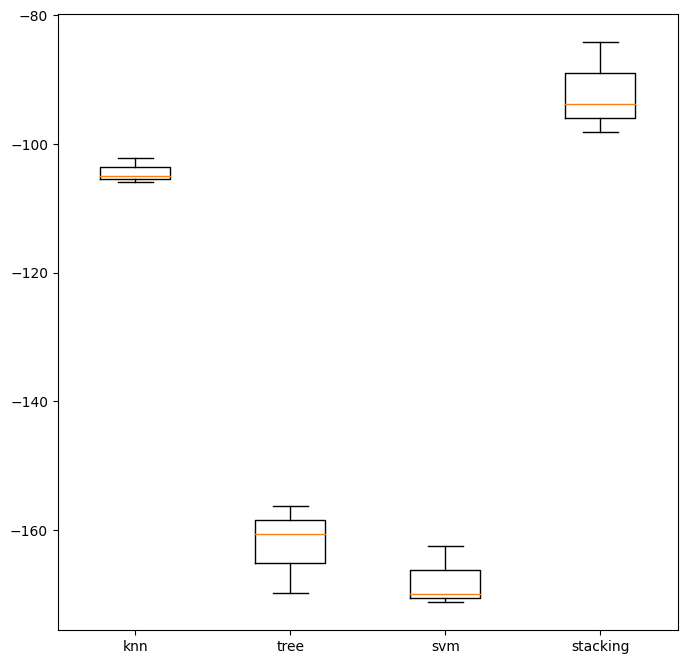

In [34]:
# stacking이 더 좋은 성능
plt.figure(figsize=(8,8))
plt.boxplot(all_result, labels=names+["stacking"])
plt.show()

In [36]:
# stacking에 전체 train data를 넣어서 성능 평가
for name, model in models.items():
  test_pred = model.predict(test_data)
  acc = mean_absolute_error(test_label, test_pred)
  print(f"Model {name} test mean absolute error is {acc:.4f}")


stacking.fit(train_data, train_label)
stacking_pred = stacking.predict(test_data)
stacking_mae = mean_absolute_error(test_label, stacking_pred)
print(f"Model stacking mean absolute error is {stacking_mae:.4f}")
              

Model knn test mean absolute error is 97.7661
Model tree test mean absolute error is 161.5555
Model svm test mean absolute error is 162.5530
Model stacking mean absolute error is 81.3265
